In [1]:
EXPERIMENT = '03-05'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearnex import patch_sklearn
patch_sklearn()

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [4]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [5]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [6]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [7]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [8]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [9]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [10]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [11]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [12]:
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.9, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

# Cross validation

## Preparation

In [13]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [14]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [15]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [16]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [17]:
train.set_index('id', inplace=True)

## Training models

In [18]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    with timer('Training', logger):
        estimator = CatBoostRegressor(n_estimators=300, random_state=SEED,
                                      train_dir=os.path.join(output_dir, f'fold{num_fold}'),
                                      cat_features=discrete_features)
        estimator.fit(X_train, y_train, sample_weight=2 * y_train + 1)
    
    # 予測結果を保存する
    with timer('Prediction', logger):
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_test = pd.DataFrame(data=estimator.predict(X_test.drop(columns=['id'])), columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump(estimator, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.191486
0:	learn: 0.6696962	total: 215ms	remaining: 1m 4s
1:	learn: 0.6254783	total: 280ms	remaining: 41.7s
2:	learn: 0.5924978	total: 340ms	remaining: 33.7s
3:	learn: 0.5545632	total: 404ms	remaining: 29.9s
4:	learn: 0.5280583	total: 470ms	remaining: 27.7s
5:	learn: 0.5063177	total: 545ms	remaining: 26.7s
6:	learn: 0.4913587	total: 618ms	remaining: 25.9s
7:	learn: 0.4817459	total: 684ms	remaining: 25s
8:	learn: 0.4739720	total: 754ms	remaining: 24.4s
9:	learn: 0.4671825	total: 821ms	remaining: 23.8s
10:	learn: 0.4622614	total: 879ms	remaining: 23.1s
11:	learn: 0.4562559	total: 955ms	remaining: 22.9s
12:	learn: 0.4512361	total: 1.02s	remaining: 22.6s
13:	learn: 0.4462730	total: 1.08s	remaining: 22.1s
14:	learn: 0.4419958	total: 1.15s	remaining: 21.9s
15:	learn: 0.4395797	total: 1.28s	remaining: 22.7s
16:	learn: 0.4374642	total: 1.35s	remaining: 22.4s
17:	learn: 0.4342964	total: 1.4s	remaining: 22s
18:	learn: 0.4327502	total: 1.46s	remaining: 21.6s
19:	learn: 0.429

163:	learn: 0.3680196	total: 10.1s	remaining: 8.39s
164:	learn: 0.3678994	total: 10.2s	remaining: 8.32s
165:	learn: 0.3675500	total: 10.2s	remaining: 8.26s
166:	learn: 0.3673743	total: 10.3s	remaining: 8.19s
167:	learn: 0.3671845	total: 10.3s	remaining: 8.13s
168:	learn: 0.3670284	total: 10.4s	remaining: 8.06s
169:	learn: 0.3668835	total: 10.5s	remaining: 7.99s
170:	learn: 0.3665811	total: 10.5s	remaining: 7.93s
171:	learn: 0.3664449	total: 10.6s	remaining: 7.86s
172:	learn: 0.3662984	total: 10.6s	remaining: 7.79s
173:	learn: 0.3660765	total: 10.7s	remaining: 7.73s
174:	learn: 0.3658417	total: 10.7s	remaining: 7.66s
175:	learn: 0.3657126	total: 10.8s	remaining: 7.6s
176:	learn: 0.3656190	total: 10.9s	remaining: 7.54s
177:	learn: 0.3653642	total: 10.9s	remaining: 7.48s
178:	learn: 0.3651925	total: 11s	remaining: 7.41s
179:	learn: 0.3650193	total: 11s	remaining: 7.35s
180:	learn: 0.3647132	total: 11.1s	remaining: 7.28s
181:	learn: 0.3645395	total: 11.1s	remaining: 7.22s
182:	learn: 0.364

25:	learn: 0.4202245	total: 1.7s	remaining: 17.9s
26:	learn: 0.4195229	total: 1.79s	remaining: 18.1s
27:	learn: 0.4186845	total: 1.84s	remaining: 17.9s
28:	learn: 0.4177506	total: 1.91s	remaining: 17.8s
29:	learn: 0.4173644	total: 1.97s	remaining: 17.8s
30:	learn: 0.4167356	total: 2.03s	remaining: 17.6s
31:	learn: 0.4158029	total: 2.09s	remaining: 17.5s
32:	learn: 0.4146614	total: 2.14s	remaining: 17.4s
33:	learn: 0.4143490	total: 2.2s	remaining: 17.2s
34:	learn: 0.4135558	total: 2.26s	remaining: 17.1s
35:	learn: 0.4131296	total: 2.32s	remaining: 17s
36:	learn: 0.4128275	total: 2.39s	remaining: 17s
37:	learn: 0.4123346	total: 2.45s	remaining: 16.9s
38:	learn: 0.4118140	total: 2.51s	remaining: 16.8s
39:	learn: 0.4113121	total: 2.56s	remaining: 16.6s
40:	learn: 0.4106976	total: 2.61s	remaining: 16.5s
41:	learn: 0.4100411	total: 2.67s	remaining: 16.4s
42:	learn: 0.4092592	total: 2.73s	remaining: 16.3s
43:	learn: 0.4088232	total: 2.79s	remaining: 16.2s
44:	learn: 0.4080553	total: 2.85s	rem

188:	learn: 0.3628205	total: 11.5s	remaining: 6.75s
189:	learn: 0.3626886	total: 11.6s	remaining: 6.69s
190:	learn: 0.3625302	total: 11.6s	remaining: 6.62s
191:	learn: 0.3623665	total: 11.7s	remaining: 6.56s
192:	learn: 0.3621727	total: 11.7s	remaining: 6.5s
193:	learn: 0.3618702	total: 11.8s	remaining: 6.45s
194:	learn: 0.3616544	total: 11.9s	remaining: 6.39s
195:	learn: 0.3614834	total: 11.9s	remaining: 6.32s
196:	learn: 0.3614054	total: 12s	remaining: 6.27s
197:	learn: 0.3613074	total: 12s	remaining: 6.2s
198:	learn: 0.3610820	total: 12.1s	remaining: 6.14s
199:	learn: 0.3608753	total: 12.2s	remaining: 6.08s
200:	learn: 0.3608425	total: 12.2s	remaining: 6.01s
201:	learn: 0.3607117	total: 12.3s	remaining: 5.95s
202:	learn: 0.3606138	total: 12.3s	remaining: 5.88s
203:	learn: 0.3604412	total: 12.4s	remaining: 5.82s
204:	learn: 0.3602733	total: 12.4s	remaining: 5.75s
205:	learn: 0.3601928	total: 12.5s	remaining: 5.7s
206:	learn: 0.3599469	total: 12.5s	remaining: 5.63s
207:	learn: 0.35987

50:	learn: 0.4034517	total: 2.94s	remaining: 14.3s
51:	learn: 0.4031351	total: 3.02s	remaining: 14.4s
52:	learn: 0.4025992	total: 3.08s	remaining: 14.3s
53:	learn: 0.4023099	total: 3.13s	remaining: 14.3s
54:	learn: 0.4017541	total: 3.21s	remaining: 14.3s
55:	learn: 0.4009124	total: 3.26s	remaining: 14.2s
56:	learn: 0.4001976	total: 3.36s	remaining: 14.3s
57:	learn: 0.3996323	total: 3.42s	remaining: 14.3s
58:	learn: 0.3990830	total: 3.47s	remaining: 14.2s
59:	learn: 0.3984900	total: 3.52s	remaining: 14.1s
60:	learn: 0.3978242	total: 3.6s	remaining: 14.1s
61:	learn: 0.3974239	total: 3.67s	remaining: 14.1s
62:	learn: 0.3968321	total: 3.76s	remaining: 14.1s
63:	learn: 0.3959120	total: 3.81s	remaining: 14.1s
64:	learn: 0.3952772	total: 3.9s	remaining: 14.1s
65:	learn: 0.3947921	total: 3.95s	remaining: 14s
66:	learn: 0.3940329	total: 4.01s	remaining: 13.9s
67:	learn: 0.3935794	total: 4.08s	remaining: 13.9s
68:	learn: 0.3931492	total: 4.13s	remaining: 13.8s
69:	learn: 0.3925125	total: 4.18s	r

213:	learn: 0.3571121	total: 12.7s	remaining: 5.08s
214:	learn: 0.3569474	total: 12.7s	remaining: 5.02s
215:	learn: 0.3566855	total: 12.8s	remaining: 4.97s
216:	learn: 0.3565232	total: 12.8s	remaining: 4.91s
217:	learn: 0.3563620	total: 12.9s	remaining: 4.85s
218:	learn: 0.3561885	total: 12.9s	remaining: 4.79s
219:	learn: 0.3559681	total: 13s	remaining: 4.73s
220:	learn: 0.3557926	total: 13.1s	remaining: 4.67s
221:	learn: 0.3555498	total: 13.1s	remaining: 4.61s
222:	learn: 0.3554319	total: 13.2s	remaining: 4.56s
223:	learn: 0.3552852	total: 13.3s	remaining: 4.5s
224:	learn: 0.3551111	total: 13.3s	remaining: 4.44s
225:	learn: 0.3548857	total: 13.4s	remaining: 4.38s
226:	learn: 0.3546507	total: 13.4s	remaining: 4.32s
227:	learn: 0.3544782	total: 13.5s	remaining: 4.26s
228:	learn: 0.3543242	total: 13.5s	remaining: 4.2s
229:	learn: 0.3541207	total: 13.6s	remaining: 4.14s
230:	learn: 0.3538838	total: 13.7s	remaining: 4.08s
231:	learn: 0.3537473	total: 13.7s	remaining: 4.02s
232:	learn: 0.35

76:	learn: 0.3890511	total: 4.5s	remaining: 13s
77:	learn: 0.3884680	total: 4.56s	remaining: 13s
78:	learn: 0.3879551	total: 4.62s	remaining: 12.9s
79:	learn: 0.3873937	total: 4.68s	remaining: 12.9s
80:	learn: 0.3871662	total: 4.74s	remaining: 12.8s
81:	learn: 0.3869471	total: 4.79s	remaining: 12.7s
82:	learn: 0.3867154	total: 4.85s	remaining: 12.7s
83:	learn: 0.3863496	total: 4.9s	remaining: 12.6s
84:	learn: 0.3859326	total: 4.96s	remaining: 12.5s
85:	learn: 0.3855005	total: 5.01s	remaining: 12.5s
86:	learn: 0.3851500	total: 5.08s	remaining: 12.4s
87:	learn: 0.3846205	total: 5.13s	remaining: 12.4s
88:	learn: 0.3842170	total: 5.18s	remaining: 12.3s
89:	learn: 0.3837471	total: 5.24s	remaining: 12.2s
90:	learn: 0.3833278	total: 5.29s	remaining: 12.2s
91:	learn: 0.3829151	total: 5.34s	remaining: 12.1s
92:	learn: 0.3826217	total: 5.39s	remaining: 12s
93:	learn: 0.3823711	total: 5.44s	remaining: 11.9s
94:	learn: 0.3818579	total: 5.5s	remaining: 11.9s
95:	learn: 0.3817180	total: 5.54s	remain

236:	learn: 0.3524150	total: 14.1s	remaining: 3.75s
237:	learn: 0.3521866	total: 14.2s	remaining: 3.69s
238:	learn: 0.3520649	total: 14.2s	remaining: 3.63s
239:	learn: 0.3519148	total: 14.3s	remaining: 3.57s
240:	learn: 0.3518937	total: 14.3s	remaining: 3.51s
241:	learn: 0.3517459	total: 14.4s	remaining: 3.45s
242:	learn: 0.3516695	total: 14.5s	remaining: 3.39s
243:	learn: 0.3515011	total: 14.5s	remaining: 3.34s
244:	learn: 0.3513738	total: 14.6s	remaining: 3.28s
245:	learn: 0.3512445	total: 14.7s	remaining: 3.22s
246:	learn: 0.3511603	total: 14.7s	remaining: 3.16s
247:	learn: 0.3510279	total: 14.8s	remaining: 3.1s
248:	learn: 0.3509119	total: 14.8s	remaining: 3.04s
249:	learn: 0.3507312	total: 14.9s	remaining: 2.98s
250:	learn: 0.3506013	total: 15s	remaining: 2.92s
251:	learn: 0.3504223	total: 15s	remaining: 2.87s
252:	learn: 0.3503067	total: 15.1s	remaining: 2.81s
253:	learn: 0.3500940	total: 15.2s	remaining: 2.75s
254:	learn: 0.3499367	total: 15.2s	remaining: 2.69s
255:	learn: 0.349

98:	learn: 0.3797725	total: 5.79s	remaining: 11.7s
99:	learn: 0.3794362	total: 5.84s	remaining: 11.7s
100:	learn: 0.3790662	total: 5.9s	remaining: 11.6s
101:	learn: 0.3786081	total: 5.95s	remaining: 11.6s
102:	learn: 0.3783996	total: 6s	remaining: 11.5s
103:	learn: 0.3777511	total: 6.06s	remaining: 11.4s
104:	learn: 0.3774539	total: 6.11s	remaining: 11.4s
105:	learn: 0.3770629	total: 6.17s	remaining: 11.3s
106:	learn: 0.3767259	total: 6.22s	remaining: 11.2s
107:	learn: 0.3763890	total: 6.28s	remaining: 11.2s
108:	learn: 0.3761064	total: 6.37s	remaining: 11.2s
109:	learn: 0.3760670	total: 6.43s	remaining: 11.1s
110:	learn: 0.3759075	total: 6.48s	remaining: 11s
111:	learn: 0.3756331	total: 6.54s	remaining: 11s
112:	learn: 0.3754169	total: 6.59s	remaining: 10.9s
113:	learn: 0.3752874	total: 6.65s	remaining: 10.9s
114:	learn: 0.3751538	total: 6.71s	remaining: 10.8s
115:	learn: 0.3749536	total: 6.77s	remaining: 10.7s
116:	learn: 0.3744770	total: 6.82s	remaining: 10.7s
117:	learn: 0.3743197	

258:	learn: 0.3473604	total: 15.1s	remaining: 2.39s
259:	learn: 0.3471488	total: 15.2s	remaining: 2.33s
260:	learn: 0.3469660	total: 15.2s	remaining: 2.27s
261:	learn: 0.3467527	total: 15.3s	remaining: 2.21s
262:	learn: 0.3466891	total: 15.3s	remaining: 2.16s
263:	learn: 0.3464972	total: 15.4s	remaining: 2.1s
264:	learn: 0.3463583	total: 15.4s	remaining: 2.04s
265:	learn: 0.3461575	total: 15.5s	remaining: 1.98s
266:	learn: 0.3460308	total: 15.6s	remaining: 1.92s
267:	learn: 0.3459177	total: 15.6s	remaining: 1.86s
268:	learn: 0.3457633	total: 15.7s	remaining: 1.81s
269:	learn: 0.3456511	total: 15.7s	remaining: 1.75s
270:	learn: 0.3454569	total: 15.8s	remaining: 1.69s
271:	learn: 0.3452715	total: 15.8s	remaining: 1.63s
272:	learn: 0.3451910	total: 15.9s	remaining: 1.57s
273:	learn: 0.3450664	total: 15.9s	remaining: 1.51s
274:	learn: 0.3448652	total: 16s	remaining: 1.46s
275:	learn: 0.3447690	total: 16.1s	remaining: 1.4s
276:	learn: 0.3446854	total: 16.1s	remaining: 1.34s
277:	learn: 0.34

## Evaluation

In [19]:
rmse = partial(mse, squared=False)

In [20]:
metrics = defaultdict(list)

### Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-04 00:35:38,215 - __main__ - INFO - CV fold 1 training loss=93.5270737
2021-08-04 00:35:38,246 - __main__ - INFO - CV fold 2 training loss=93.5368818
2021-08-04 00:35:38,268 - __main__ - INFO - CV fold 3 training loss=92.2211870
2021-08-04 00:35:38,289 - __main__ - INFO - CV fold 4 training loss=92.1919610
2021-08-04 00:35:38,310 - __main__ - INFO - CV fold 5 training loss=91.7733635
2021-08-04 00:35:38,310 - __main__ - INFO - CV training loss: average=92.6500934, std=0.7372909


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [23]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-04 00:35:38,516 - __main__ - INFO - Training loss: 106.7029746


### Validation set

In [24]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-04 00:35:38,541 - __main__ - INFO - CV fold 1 validation loss=100.2774399
2021-08-04 00:35:38,551 - __main__ - INFO - CV fold 2 validation loss=104.6828732
2021-08-04 00:35:38,567 - __main__ - INFO - CV fold 3 validation loss=106.6071550
2021-08-04 00:35:38,598 - __main__ - INFO - CV fold 4 validation loss=106.9646379
2021-08-04 00:35:38,617 - __main__ - INFO - CV fold 5 validation loss=109.0454322
2021-08-04 00:35:38,617 - __main__ - INFO - CV validation loss: average=105.5155076, std=2.9625217


In [25]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [26]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-04 00:35:38,825 - __main__ - INFO - Validation loss: 198.3822698


In [27]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


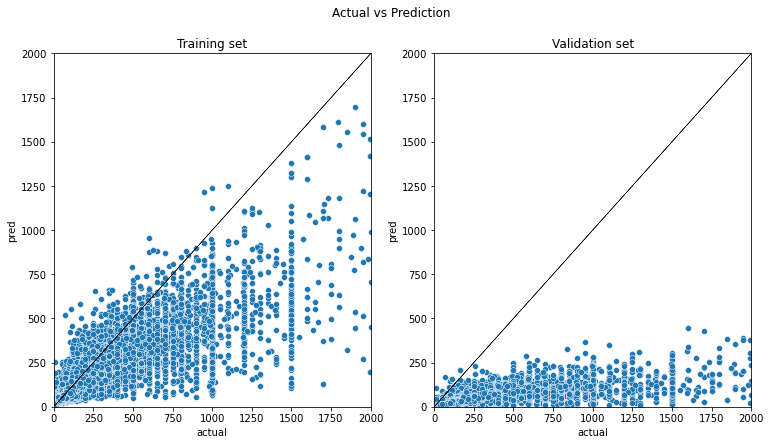

In [28]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

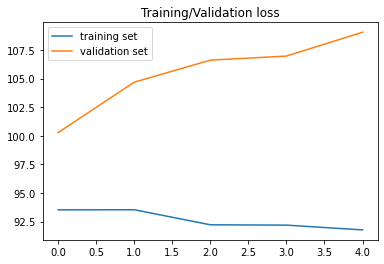

In [29]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [30]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [31]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [32]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

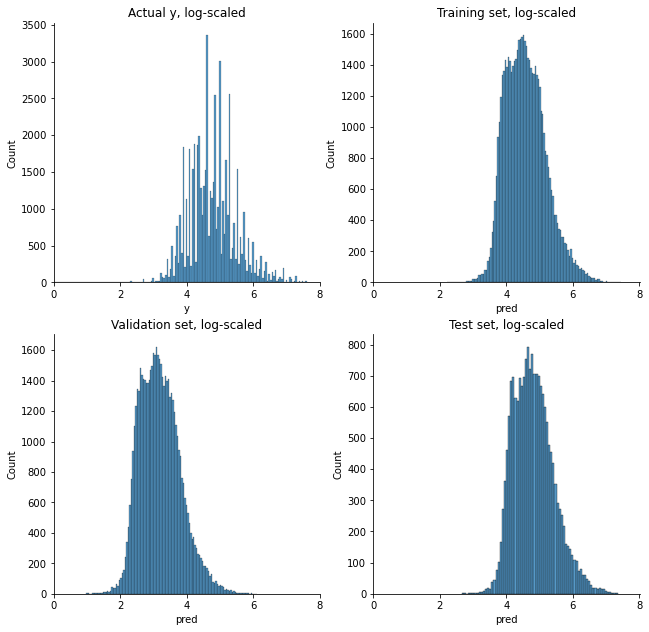

In [33]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [34]:
logger.debug('Complete({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Feature importance

In [35]:
pd.options.display.float_format = '{:.5f}'.format

In [36]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

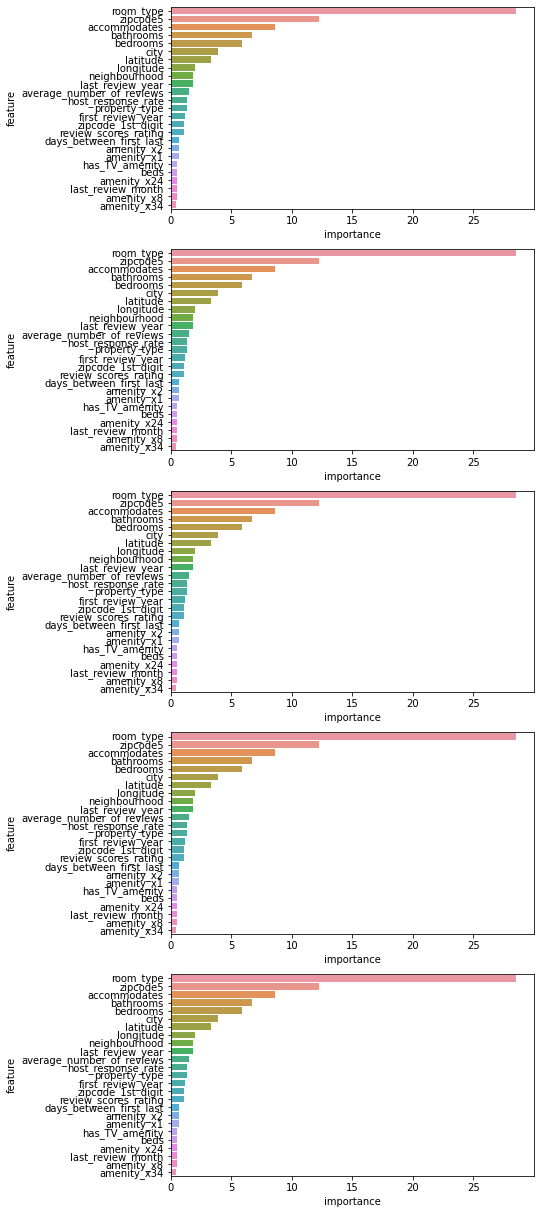

In [37]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model.feature_importances_, columns=['importance'])
    imp_df['feature'] = model.feature_names_
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance.png'))

# Error

In [38]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [39]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

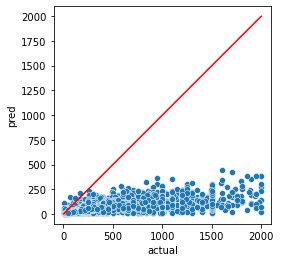

In [40]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

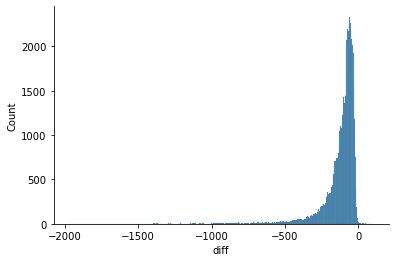

In [41]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [42]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [43]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\03-05\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 1min 5s


In [44]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [45]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [46]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [47]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [48]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                             -0.47713
bedrooms                                 -0.45277
bathrooms                                -0.41755
beds                                     -0.39626
room_type                                -0.26848
has_Familykid-friendly_amenity           -0.19120
has_Indoor-fireplace_amenity             -0.16669
has_TV_amenity                           -0.16144
has_Cable-TV_amenity                     -0.15580
has_Dryer_amenity                        -0.14241
has_Washer_amenity                       -0.13940
amenity_x1                               -0.13748
has_Suitable-for-events_amenity          -0.13524
amenity_x3                               -0.11453
has_thumbnail                            -0.11151
has_Hot-tub_amenity                      -0.07627
has_Gym_amenity                          -0.07536
has_Pool_amenity                         -0.07318
has_Doorman_amenity                      -0.07075
has_Free-parking-on-premises_amenity     -0.06617


In [49]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [50]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [51]:
imp_df['feature'] = estimator.feature_name_

In [52]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df.head(25)

,importance,feature
3,984468014.00391,bedrooms
1,603647255.00000,bathrooms
0,515724442.60938,accommodates
13,292428865.79688,longitude
12,276918033.89844,latitude
18,241739823.09766,room_type
155,119208611.00000,last_review_year
144,74055336.00000,average_number_of_reviews
17,52694006.50000,review_scores_rating
10,51155740.00000,host_response_rate


In [53]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)